In [1]:
from anyBSM.plotting import ScanParameter, Plotting, setAnyStyle
import anyBSM.plotting as plotting
plotting.anyLogo = {'resize': 1.5, 'show': False, 'alpha': 0.4, 'zorder': 0, 'loc': 'lower right'}
from anyBSM import anyBSM
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import cmath, math
from matplotlib.ticker import MultipleLocator
setAnyStyle()

## Initialize Y=1 triplet model

In [2]:
TSM = anyBSM('TSM_Yeq1', quiet=True, progress=False, ask=False, scheme_name="OS")

## Check renormalisation scale dependence

In [3]:
TSM.evaluation = 'numerical'
TSM.setparameters({'MDPP': 300, 'MDP': 250, 'lam4': 1})
TSM.setparameters({'Qren': 170})
lam_Qren170 = TSM.lambdahhh()

TSM.setparameters({'Qren': 1700})
lam_Qren1700 = TSM.lambdahhh()
lam_Qren170['total'] - lam_Qren1700['total']

(5.684341886080802e-14+0j)

## Reproduce Fig. 11 of 1211.6029

In [4]:
lam4in = ScanParameter(TSM.parameters['lam4'], distribution='grid', start = -1, stop = 5)
plot = Plotting(TSM)

In [3]:
@np.vectorize
def calc_klam(mdpp, mdp, l4, real_part=True):
    TSM.setparameters({'MDPP': mdpp, 'MDP': mdp, 'lam4': l4, 'MT': 172.76, 'ymt': 172.76, 'MH': 125.09, 'aEWM1': 137.035999084, 'cabi': 0, 'MB': 0, 'MC': 0, 'MS': 0, 'MU': 0, 'MD': 0, 'Me': 0, 'MMU': 0, 'MTA': 0, 'ymb': 0, 'ymc': 0, 'yms': 0, 'ymup': 0, 'ymdo': 0, 'yme': 0, 'ymm': 0, 'ymtau': 0})
    res = TSM.lambdahhh()
    if real_part:
        return np.real(res['total']/res['treelevel'])
    else:
        return np.imag(res['total']/res['treelevel'])

@np.vectorize # solve for mdpp if the lightest state is a neutral state and used as an input
def mdpp_sol(md0, dm):
    return np.sqrt(md0**2 + 4*dm*md0 + 2*dm**2)

In [6]:
dm_range = np.linspace(0, 70, 30)
l4_range = np.linspace(-2, 5, 30)

X, Y = np.meshgrid(l4_range, dm_range)
Z1 = calc_klam(300, 300 + Y, X)
Z2 = calc_klam(mdpp_sol(300, Y), 300 + Y, X)

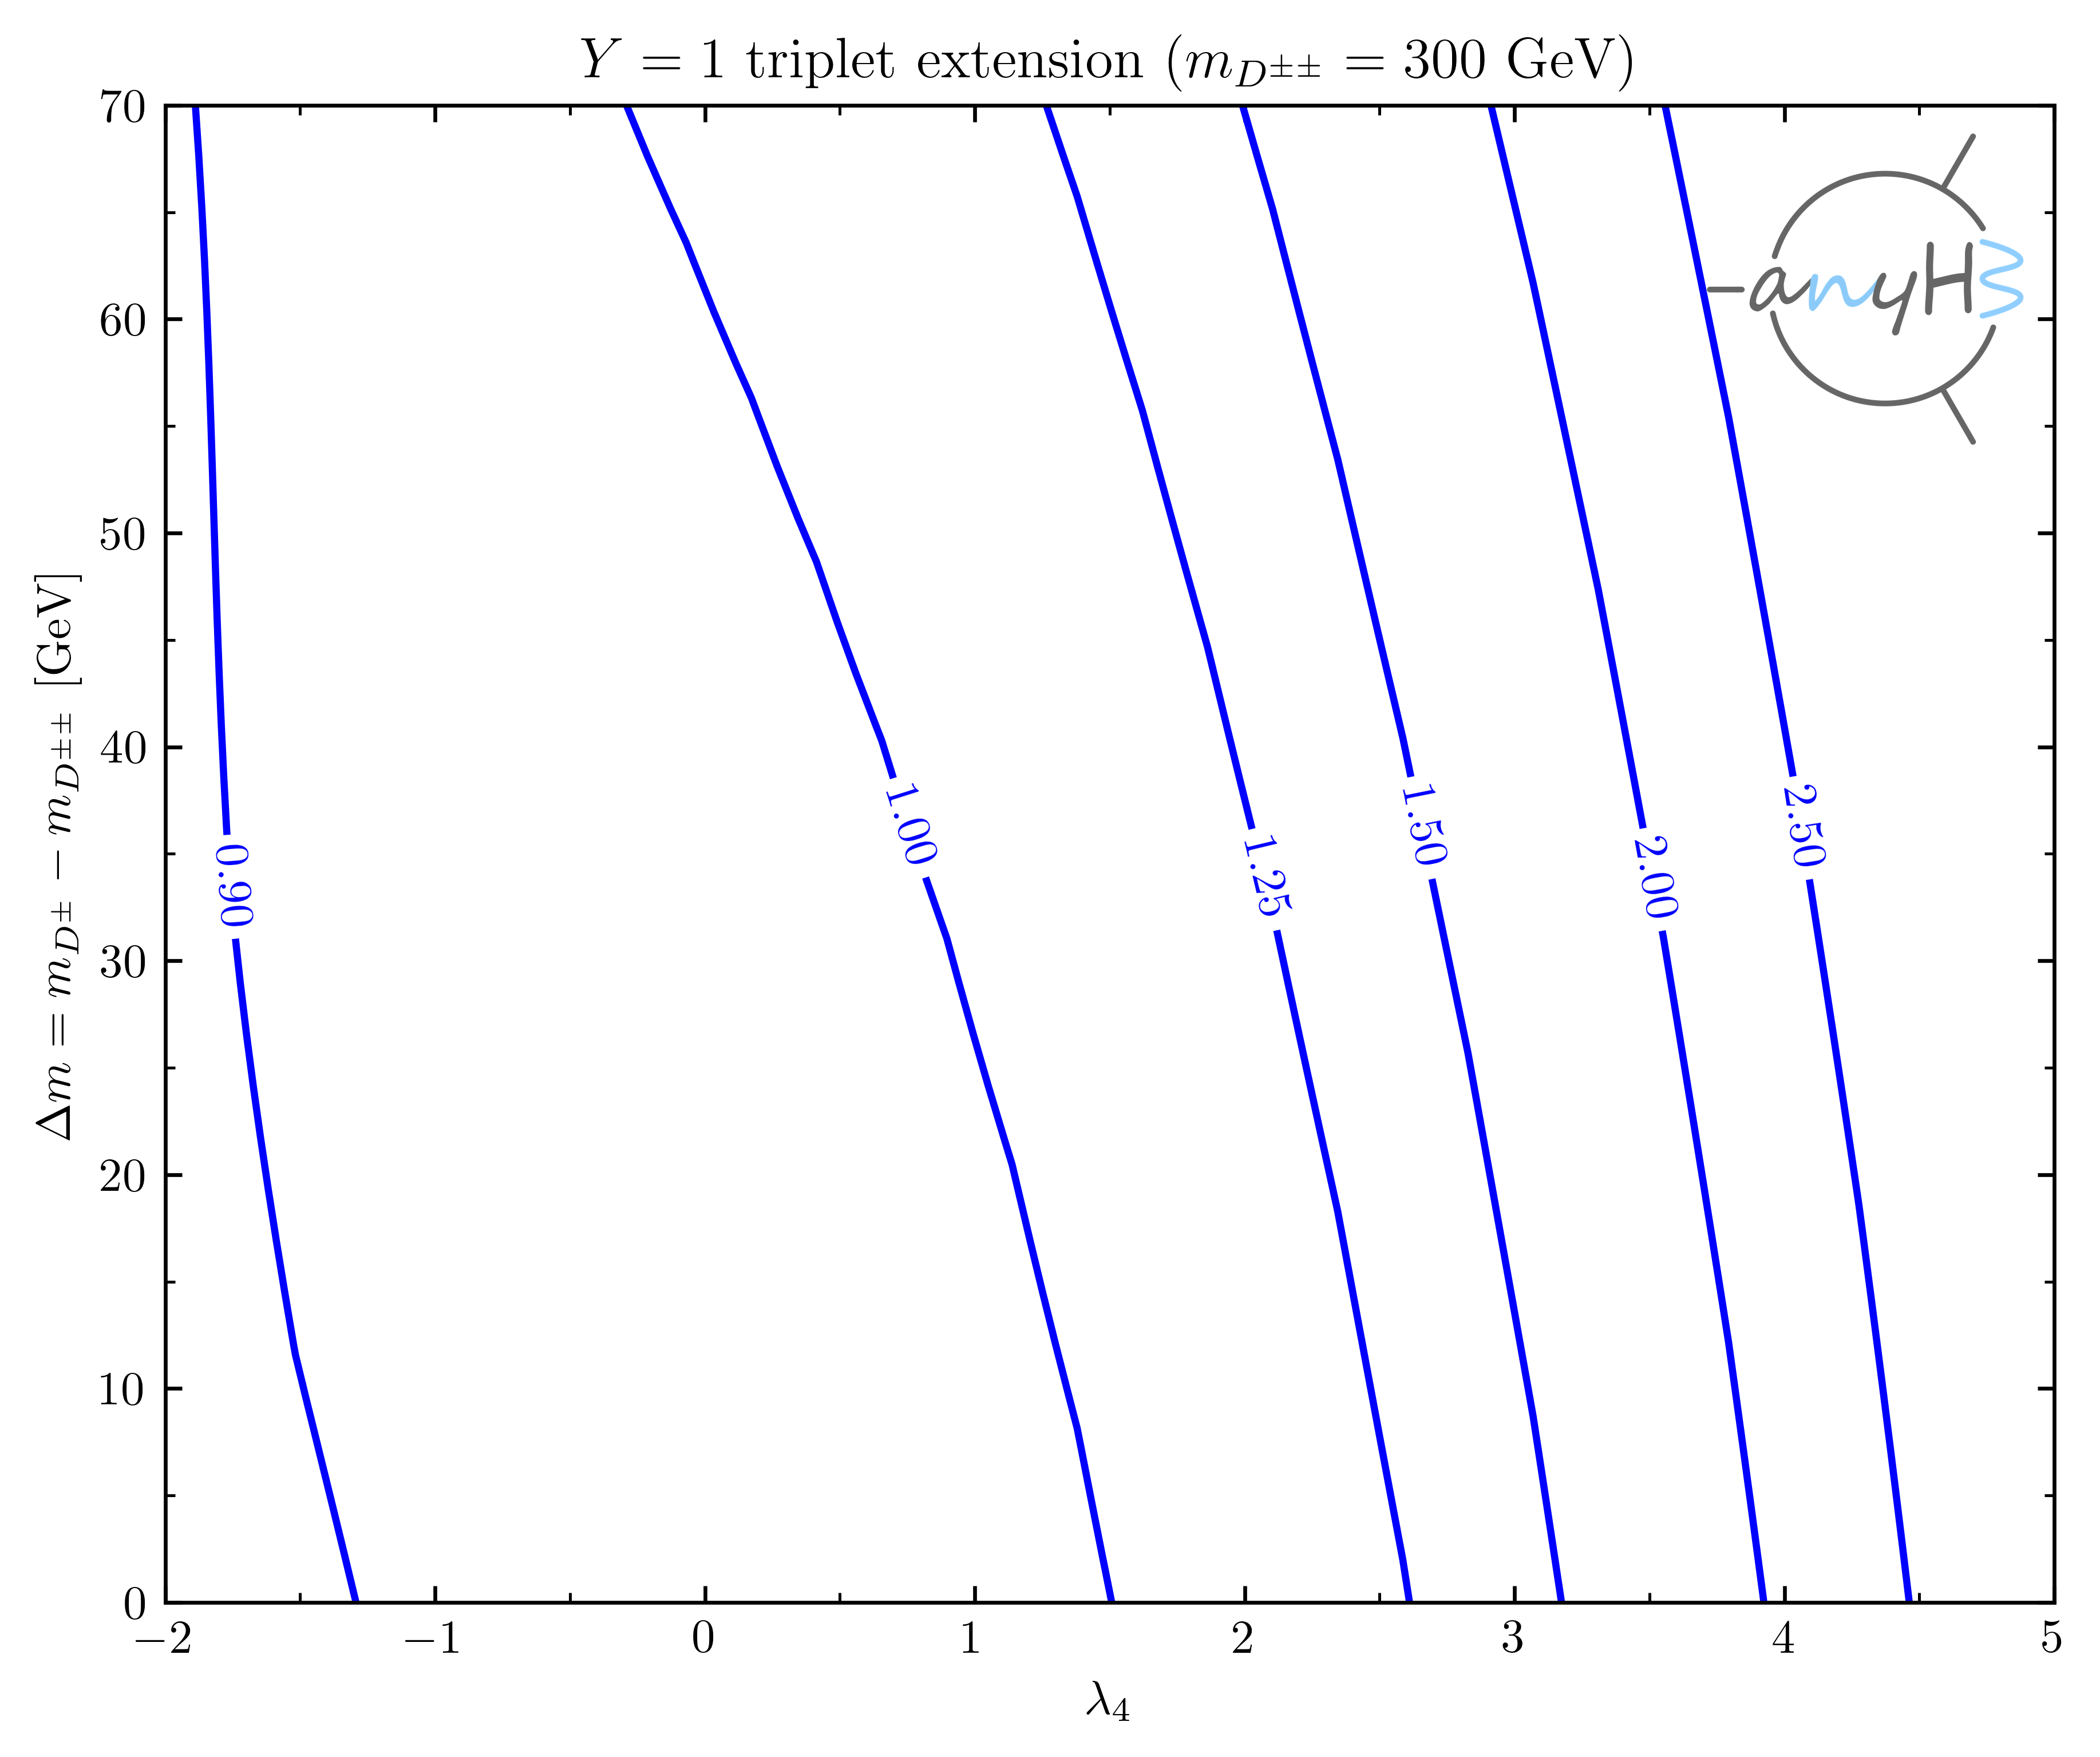

In [12]:

fig, ax = plt.subplots(constrained_layout=True, figsize=(6,5))
fig.dpi=600

cs = plt.contour(X, Y, Z1, levels = [.9, 1., 1.25, 1.5, 2., 2.5], colors='b')
plt.clabel(cs)

plt.xlabel(r'$\lambda_4$')
plt.ylabel(r'$\Delta m = m_{D^\pm} - m_{D^{\pm\pm}}$ [GeV]')

ax.xaxis.set_minor_locator(MultipleLocator(.5))
ax.xaxis.set_major_locator(MultipleLocator(1))

ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.yaxis.set_major_locator(MultipleLocator(10))

plt.title(r'$Y=1$ triplet extension ($m_{D^{\pm\pm}} = 300$ GeV)')

plotting.place_logo(fig,0.82,0.75, resize=0.4,alpha=0.6, logo_name='anyH3_logo_large.png')

plt.savefig('Yeq1_triplet_verification_1.pdf', bbox_inches='tight',dpi=fig.dpi)
plt.show()

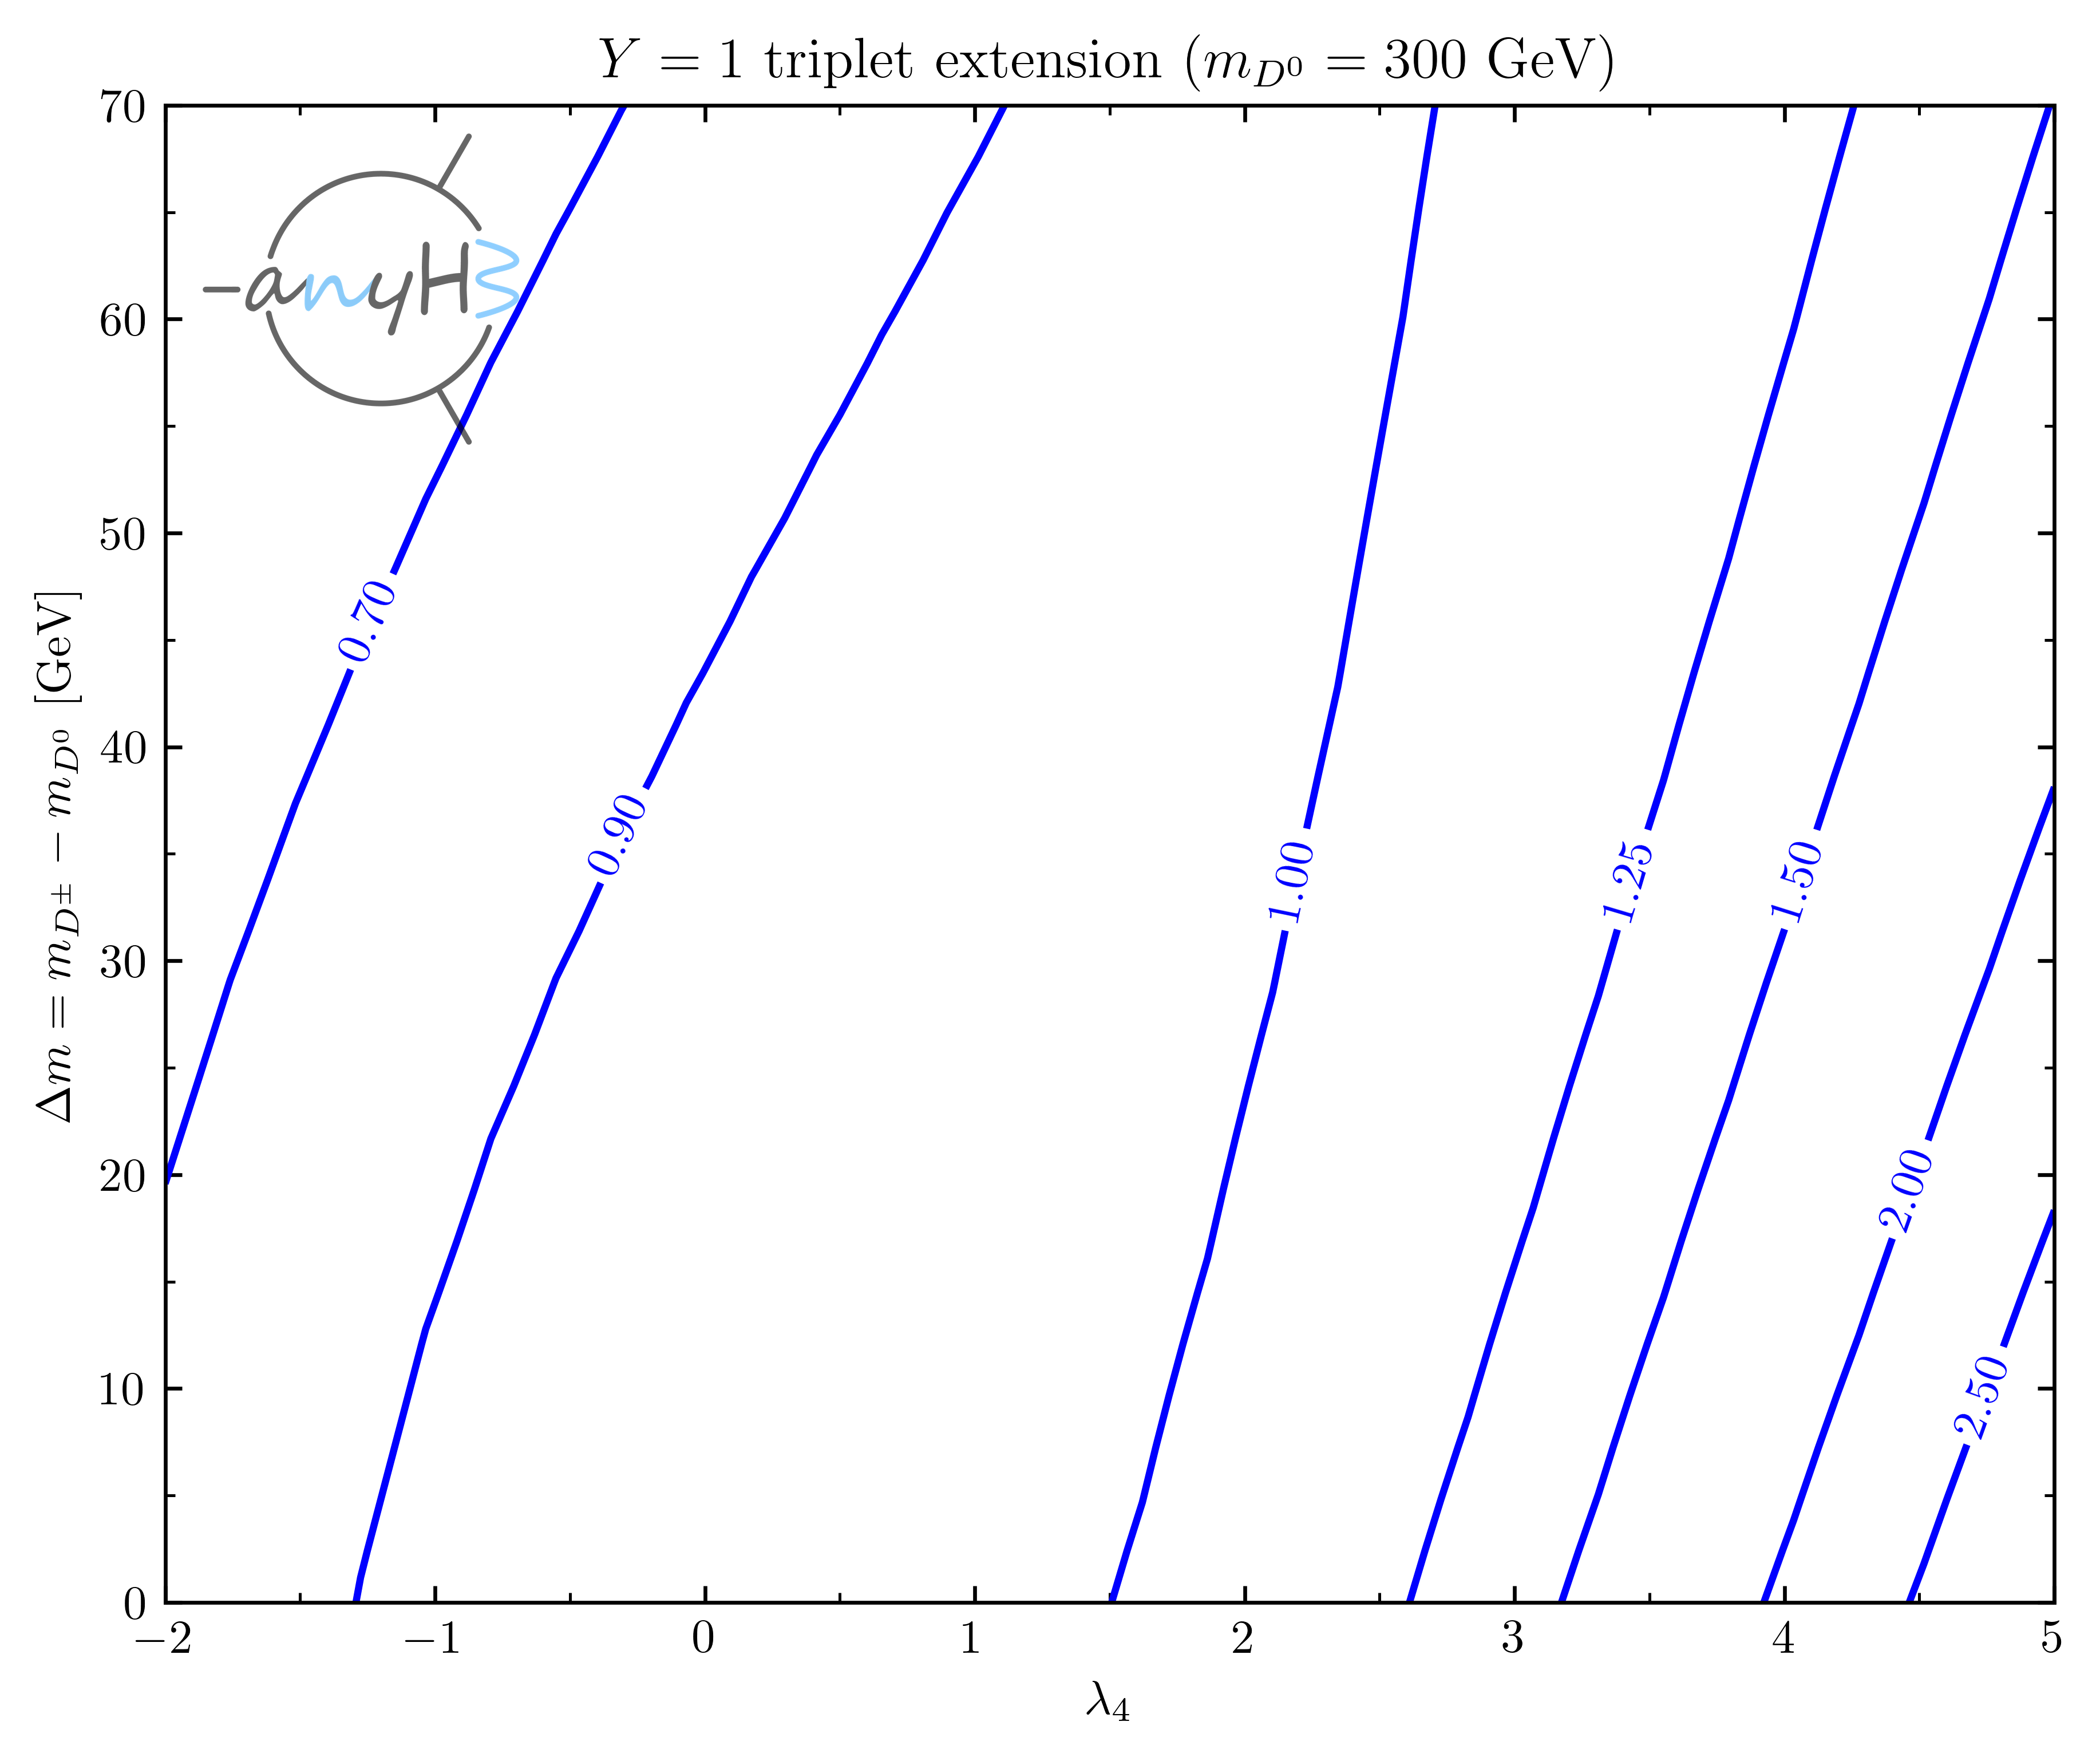

In [17]:
plotting.anyLogo['loc']='upper left'
fig, ax = plt.subplots(constrained_layout=True, figsize=(6,5))
fig.dpi=600

cs = plt.contour(X, Y, Z2, levels = [.7, .9, 1., 1.25, 1.5, 2., 2.5], colors='b')
plt.clabel(cs)

plt.xlabel(r'$\lambda_4$')
plt.ylabel(r'$\Delta m = m_{D^\pm} - m_{D^0}$ [GeV]')

ax.xaxis.set_minor_locator(MultipleLocator(.5))
ax.xaxis.set_major_locator(MultipleLocator(1))

ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.yaxis.set_major_locator(MultipleLocator(10))

plt.title(r'$Y=1$ triplet extension ($m_{D^{0}} = 300$ GeV)')

plotting.place_logo(fig,0.09,0.75, resize=0.4,alpha=0.6, logo_name='anyH3_logo_large.png')

plt.savefig('Yeq1_triplet_verification_2.pdf', bbox_inches='tight',dpi=fig.dpi)
plt.show()

## Investigation of momentum dependence

In [4]:
TSM_w_offshell_leg = anyBSM(anyBSM.built_in_models['TSM_Yeq1'], quiet=True, progress=False, ask=False, scheme_name="OS_w_1_offshell_leg")

In [5]:
@np.vectorize
def calc_klam_p2(mdpp, mdp, l4, p2zero = True, shat = 0):
    if p2zero:
        res = TSM.lambdahhh(momenta = [0, 0, 0], parameters={'MDPP': mdpp, 'MDP': mdp, 'lam4': l4}) # momenta = [0, 0, 0] corresponds to default setting
    else:
        res = TSM_w_offshell_leg.lambdahhh(momenta = [shat**2, 'MH**2', 'MH**2'], parameters={'MDPP': mdpp, 'MDP': mdp, 'lam4': l4})
    return res['total'], res['treelevel']

In [6]:
shat_min, shat_max = 0, 1500
shat_range = np.linspace(shat_min, shat_max, 150)

res_p2_scan = calc_klam_p2(400, 500, 4, p2zero=False, shat = shat_range)
res_p2_scan_Re = np.real(res_p2_scan[0]/res_p2_scan[1]) # obtain kappa_lambda and take the real part
res_p2_scan_Im = np.imag(res_p2_scan[0]) # obtain the imaginary part of lambdahhh

res_p2_zero = calc_klam_p2(400, 500, 4, p2zero=True)
res_p2_zero = np.real(res_p2_zero[0]/res_p2_zero[1]) # obtain kappa_lambda

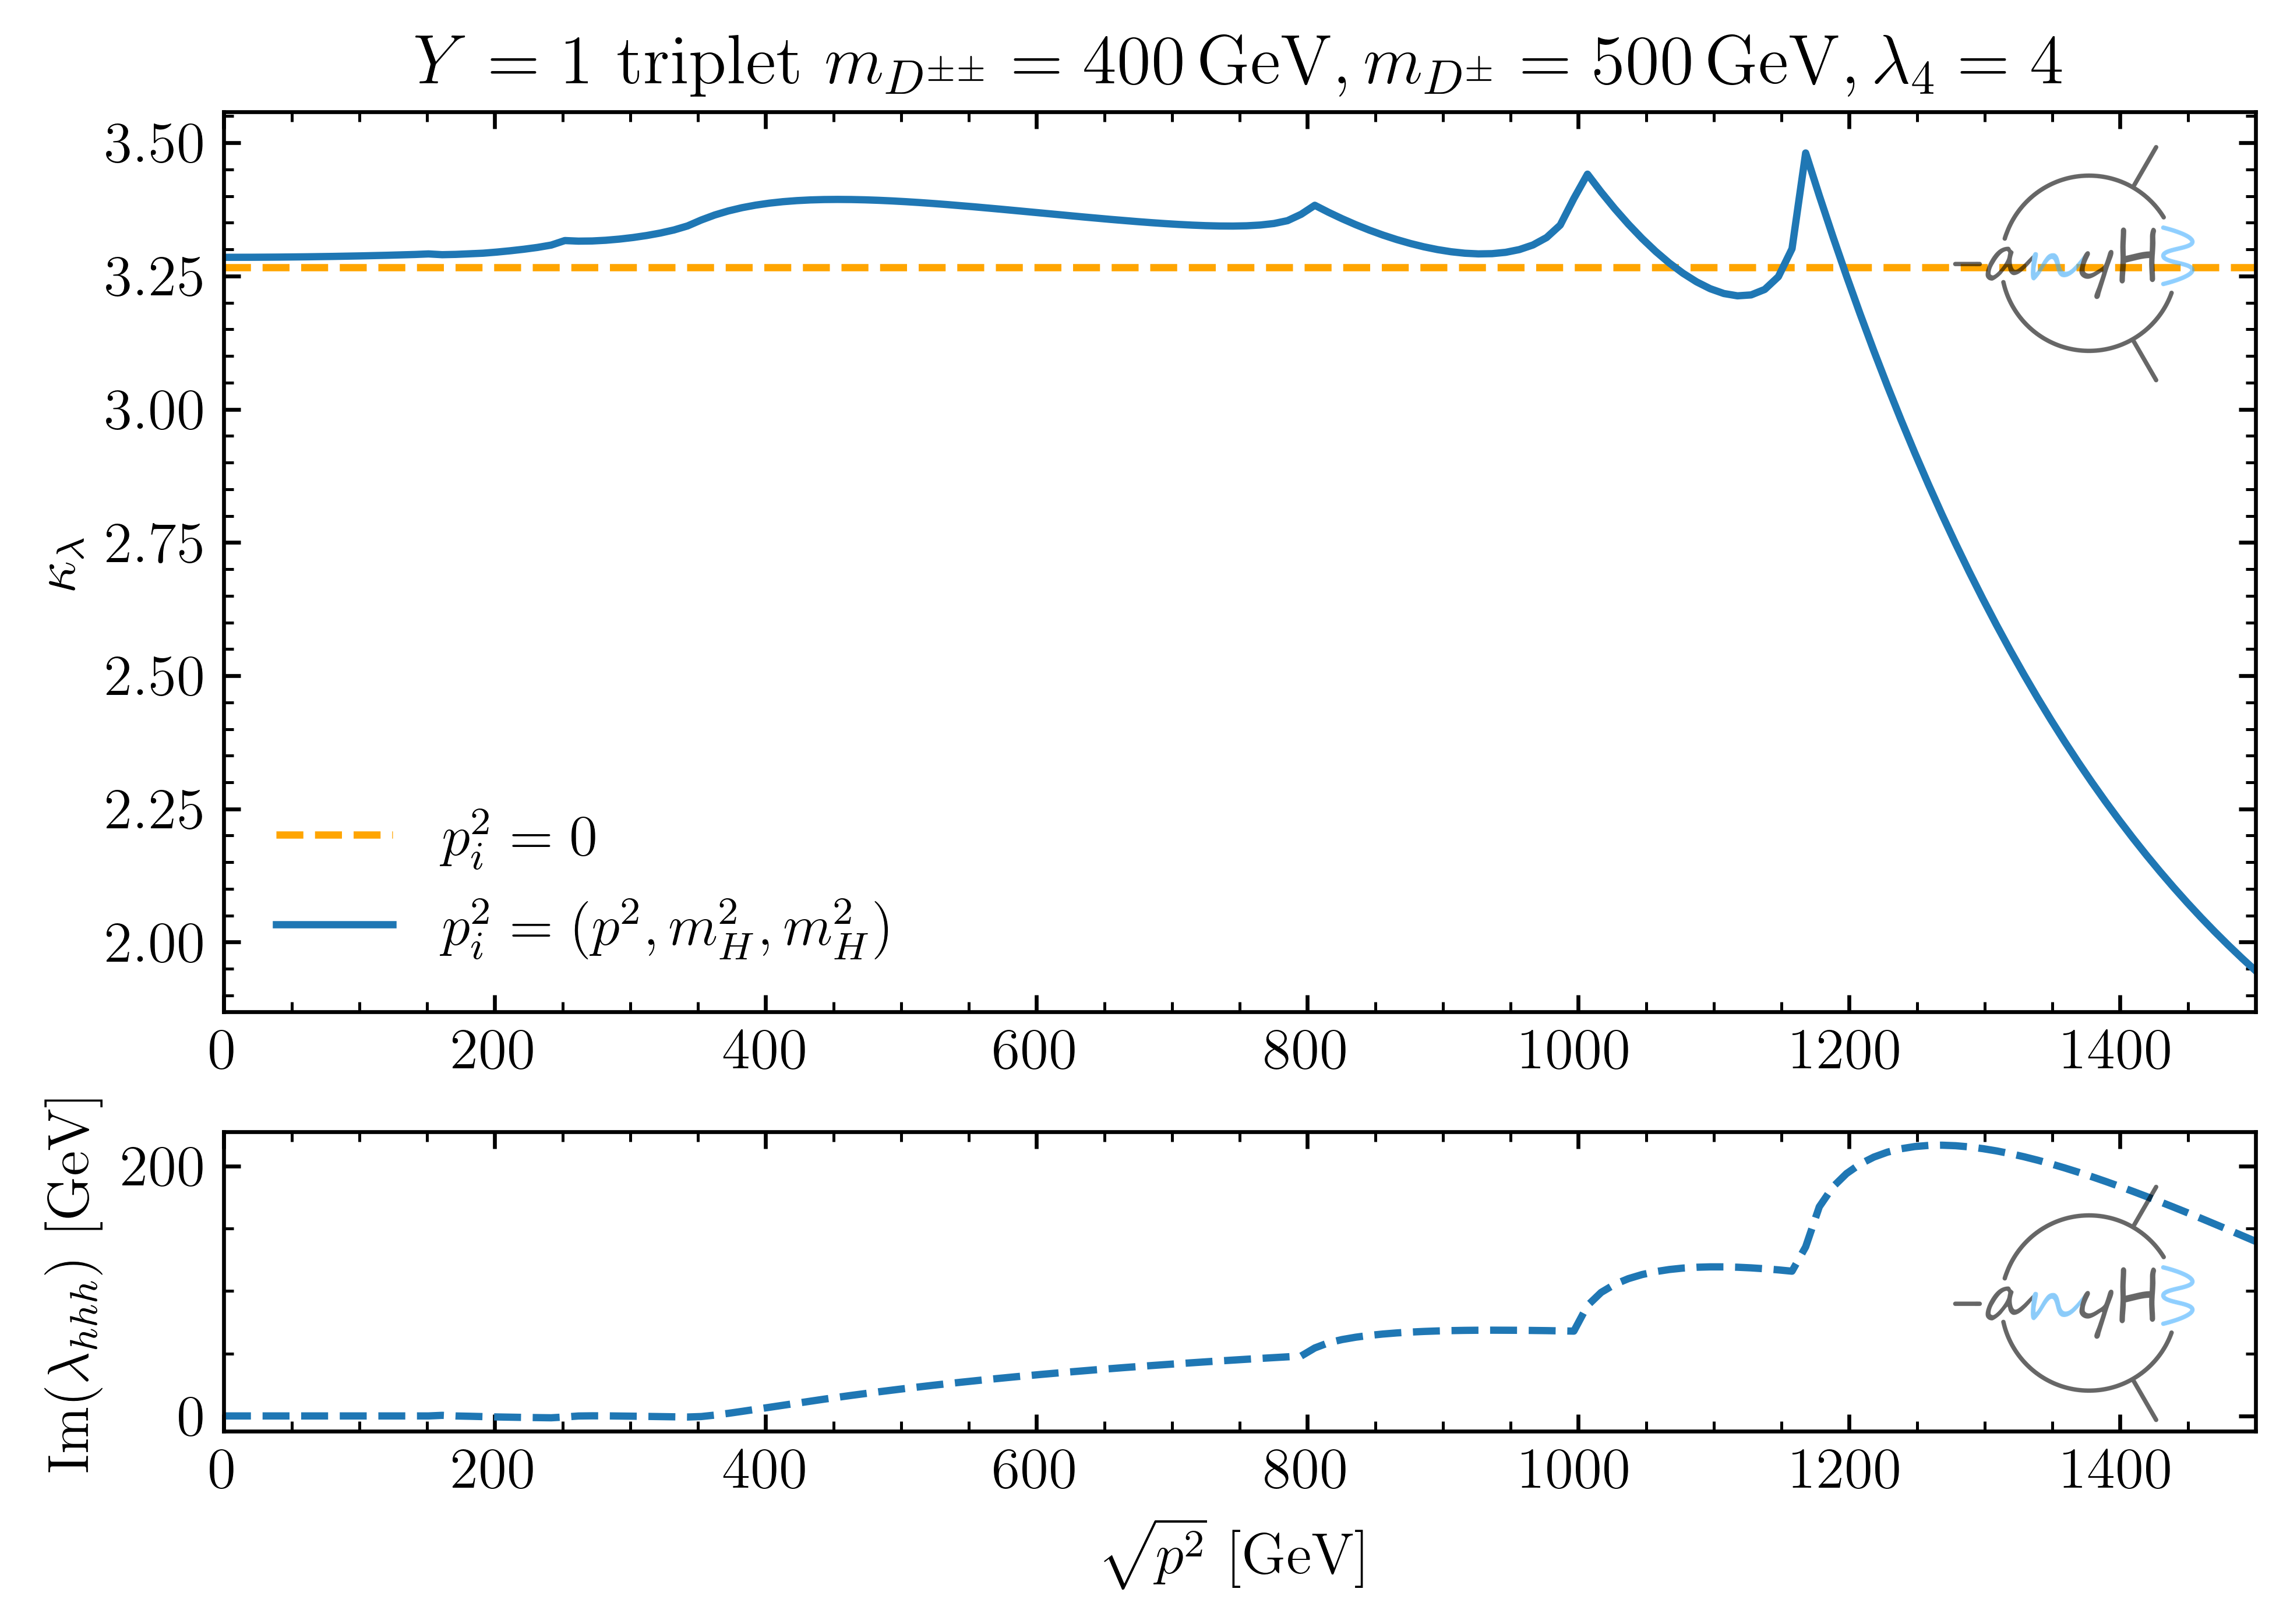

In [10]:
mpl.rcParams['font.size']   = 12.0
fig = plt.figure(figsize = (7.5, 5))
fig.dpi=600
spec = mpl.gridspec.GridSpec(ncols=1, nrows=2, height_ratios = [3, 1])
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])

ax1.hlines(res_p2_zero, shat_min, shat_max, ls='--', colors=['orange'], label=r'$p_i^2 = 0$')
ax1.plot(shat_range, res_p2_scan_Re, label=r'$p_i^2 = (p^2, m_H^2, m_H^2)$')

ax2.plot(shat_range, res_p2_scan_Im, ls='--')

ax2.set_xlabel(r'$\sqrt{p^2}$ [GeV]')
ax1.set_ylabel(r'$\kappa_\lambda$')
ax2.set_ylabel(r'Im$(\lambda_{hhh}$) [GeV]')

ax1.set_xlim([shat_min, shat_max])
ax2.set_xlim([shat_min, shat_max])

#ax1.xaxis.set_minor_locator(MultipleLocator(50))
#ax1.xaxis.set_major_locator(MultipleLocator(200))
#ax1.yaxis.set_minor_locator(MultipleLocator(.05))
#ax1.yaxis.set_major_locator(MultipleLocator(.2))

#ax2.xaxis.set_minor_locator(MultipleLocator(50))
#ax2.xaxis.set_major_locator(MultipleLocator(200))
#ax2.yaxis.set_minor_locator(MultipleLocator(50))
#ax2.yaxis.set_major_locator(MultipleLocator(100))

ax1.legend(frameon=False)

ax1.set_title(r'$Y=1$ triplet $m_{D^{\pm\pm}} = 400\,\rm{GeV},\,$$m_{D^{\pm}} = 500\,\rm{GeV}, \lambda_4 = 4$')

plotting.place_logo(fig,0.74,0.7, resize=0.3, alpha=0.6, logo_name='anyH3_logo_large.png')
plotting.place_logo(fig,0.74,0.105, resize=0.3, alpha=0.6, logo_name='anyH3_logo_large.png')

plt.savefig('Yeq1_triplet_p2_dep.pdf', bbox_inches='tight',dpi=fig.dpi)
plt.show()